# Reinforcement Learning with Linear Approximation on MountainCar-v0
In questo notebook, viene proposto un approccio per risolvere il Mountain Car problem della documentazione Gym utilizzando Q-learning assieme alla Linear Function Approximation (Linear FA)

# importazione delle librerie necessarie


In [ ]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
from IPython.display import HTML
import matplotlib.animation as animation

# Funzione per visualizzare l'animazione
Questa funzione prende una lista di frame e crea un'animazione visualizzabile come GIF nel notebook.


In [ ]:
def display_frames_as_gif(frames, info_text):
    fig = plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])
        plt.title(info_text[i])  # Aggiunge informazioni come titolo del frame

    ani = animation.FuncAnimation(fig, animate, frames=len(frames), interval=50)
    plt.close()
    return HTML(ani.to_jshtml())

# Classe per l'approssimazione lineare
Questa classe implementa un semplice modello di approssimazione lineare per massimizzare l'Action-Value function Q. Utilizza un array di pesi per rappresentare i valori Q per ogni azione. La strategia di esplorazione scelta è la Epsilon-greedy.


In [ ]:
# Classe per l'approssimazione lineare
class LinearApproximation:
    def __init__(self, state_size, action_size, alpha=0.01, gamma=0.99):
        self.state_size = state_size
        self.action_size = action_size
        self.alpha = alpha
        self.gamma = gamma
        self.weights = np.zeros((action_size, state_size))

    def q_value(self, state, action):
        return np.dot(self.weights[action], state)

    def policy(self, state, epsilon=0.1):
        if np.random.rand() < epsilon:
            return np.random.choice(self.action_size)
        q_values = [self.q_value(state, a) for a in range(self.action_size)]
        return np.argmax(q_values)

    # implementazione della strategia di Q-learning
    def update(self, state, action, reward, next_state, done):
        q_current = self.q_value(state, action)
        q_next = max([self.q_value(next_state, a) for a in range(self.action_size)]) if not done else 0
        target = reward + self.gamma * q_next
        error = target - q_current
        self.weights[action] += self.alpha * error * state


# Funzione di reward
La funzione di reward utilizzata varia in base alla massima coordinata X raggiunta durante l'iterazione nonchè la massima velocità che è stata raggiunta. Più sono alte, maggiore è la reward. Inoltre è presente una penalità di tempo per incentivare ulteriormente l'agente a raggiungere il più in fretta possibile la cima della collina.**testo in grassetto**

In [ ]:
def modified_reward(state, next_state, action, max_position, max_velocity):
    position, velocity = state
    next_position, next_velocity = next_state

    # Incentivo basato sulla distanza dalla bandiera
    flag_position = 0.5
    distance_to_flag = abs(next_position - flag_position)
    reward_distance = -distance_to_flag

    # Incentivo per velocità in salita (indipendentemente dalla direzione)
    reward_velocity = 0.1 * np.abs(next_velocity)

    # Ricompensa per raggiungere nuove posizioni massime
    reward_max_position = 1.5 if next_position > max_position else 0

    # Penalità per ogni step effettuato nell'ambiente
    penalty_step = -0.01

    # Combinazione delle componenti di reward
    reward_total = reward_distance + reward_velocity + reward_max_position + penalty_step

    return reward_total

# Funzione di training
Questa funzione addestra l'agente utilizzando il metodo Q-learning con l'approssimazione lineare. Utilizza una politica epsilon-greedy per bilanciare exploration ed exploitation.

In [ ]:
def train(env, agent, episodes, batch_size=64, epsilon_decay=0.995, min_epsilon=0.01, early_stopping_patience=300, moving_avg_window=100):
    rewards = []
    average_rewards = []
    epsilon = 1.0
    best_reward = -float('inf')
    best_weights = None
    best_frames = []
    no_improvement_count = 0
    max_positions = []
    max_velocities = []
    action_counts = []
    episode_lengths = []
    info_texts = []

    for episode in range(episodes):
        frames = []
        state = env.reset()
        total_reward = 0
        done = False
        max_position = -1.2
        max_velocity = -0.07
        episode_action_counts = [0] * agent.action_size
        step_count = 0
        info_text_episode = []

        while not done:
            state = np.array(state)  # Converti lo stato in un array numpy se non già fatto
            action = agent.policy(state, epsilon)
            next_state, _, done, _ = env.step(action)
            next_state = np.array(next_state)  # Converti next_state in un array numpy se non già fatto

            # Aggiorna max position e velocity
            max_position = max(max_position, next_state[0])
            max_velocity = max(max_velocity, np.abs(next_state[1]))

            reward = modified_reward(state, next_state, action, max_position, max_velocity)
            agent.update(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            frames.append(env.render(mode='rgb_array'))  # Memorizza i frames

            episode_action_counts[action] += 1
            step_count += 1
            info_text_episode.append(f"Episode: {episode+1}, Step: {step_count}, Reward: {total_reward:.2f}, Max Pos: {max_position:.2f}, Max Vel: {max_velocity:.2f}")


        # Verifica se l'episodio corrente ha ottenuto una reward migliore
        if total_reward > best_reward:
            best_reward = total_reward
            best_weights = np.copy(agent.weights)
            best_frames = frames.copy()
            info_texts = info_text_episode.copy()  # Aggiorna i testi informativi per l'animazione
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        epsilon = max(min_epsilon, epsilon * epsilon_decay)
        rewards.append(total_reward)
        average_reward = np.mean(rewards[-moving_avg_window:])
        average_rewards.append(average_reward)
        max_positions.append(max_position)
        max_velocities.append(max_velocity)
        action_counts.append(episode_action_counts)
        episode_lengths.append(step_count)

        print(f"Episode: {episode+1}, Total Reward: {total_reward}, Average Reward: {average_reward:.2f}, Max Position: {max_position:.2f}, Max Velocity: {max_velocity:.2f}, Epsilon: {epsilon:.2f}, Best Reward: {best_reward}")

        # Early stopping se non ci sono miglioramenti per un numero di episodi consecutivi
        if no_improvement_count > early_stopping_patience:
            print(f"Stopping early due to no improvement for {early_stopping_patience} episodes.")
            break

    # Restituisce le migliori ricompense, pesi e frames dell'animazione migliore
    return rewards, average_rewards, best_weights, best_frames, max_positions, max_velocities, action_counts, episode_lengths, info_texts


# Creazione dell'ambiente e addestramento dell'agente
In questa cella, creiamo l'ambiente `MountainCar-v0` e iniziamo l'addestramento dell'agente utilizzando la funzione di training definita in precedenza. E' implementata anche una strategia di early-stopping qualora i miglioramenti diventino rari.



In [ ]:
# Creazione dell'ambiente e dell'agente
env = gym.make('MountainCar-v0')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

agent = LinearApproximation(state_size, action_size)
episodes = 10000
early_stopping_patience = 3000  # Numero di episodi consecutivi senza miglioramenti prima di fermarsi
rewards, average_rewards, best_weights, best_frames, max_positions, max_velocities, action_counts, episode_lengths, info_text = train(env, agent, episodes, early_stopping_patience=early_stopping_patience)

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initiali

Episode: 1, Total Reward: -205.2147045869352, Average Reward: -205.21, Max Position: -0.39, Max Velocity: 0.01, Epsilon: 0.99, Best Reward: -205.2147045869352
Episode: 2, Total Reward: -206.0810709475552, Average Reward: -205.65, Max Position: -0.45, Max Velocity: 0.01, Epsilon: 0.99, Best Reward: -205.2147045869352
Episode: 3, Total Reward: -206.61462876661153, Average Reward: -205.97, Max Position: -0.47, Max Velocity: 0.01, Epsilon: 0.99, Best Reward: -205.2147045869352
Episode: 4, Total Reward: -208.22862426791818, Average Reward: -206.53, Max Position: -0.47, Max Velocity: 0.01, Epsilon: 0.98, Best Reward: -205.2147045869352
Episode: 5, Total Reward: -207.5070436329985, Average Reward: -206.73, Max Position: -0.40, Max Velocity: 0.01, Epsilon: 0.98, Best Reward: -205.2147045869352
Episode: 6, Total Reward: -204.4026927437708, Average Reward: -206.34, Max Position: -0.39, Max Velocity: 0.01, Epsilon: 0.97, Best Reward: -204.4026927437708
Episode: 7, Total Reward: -208.9440471000006

# Plot delle ricompense e altre statistiche
In questa cella, visualizziamo vari grafici per analizzare le performance dell'agente durante l'addestramento.

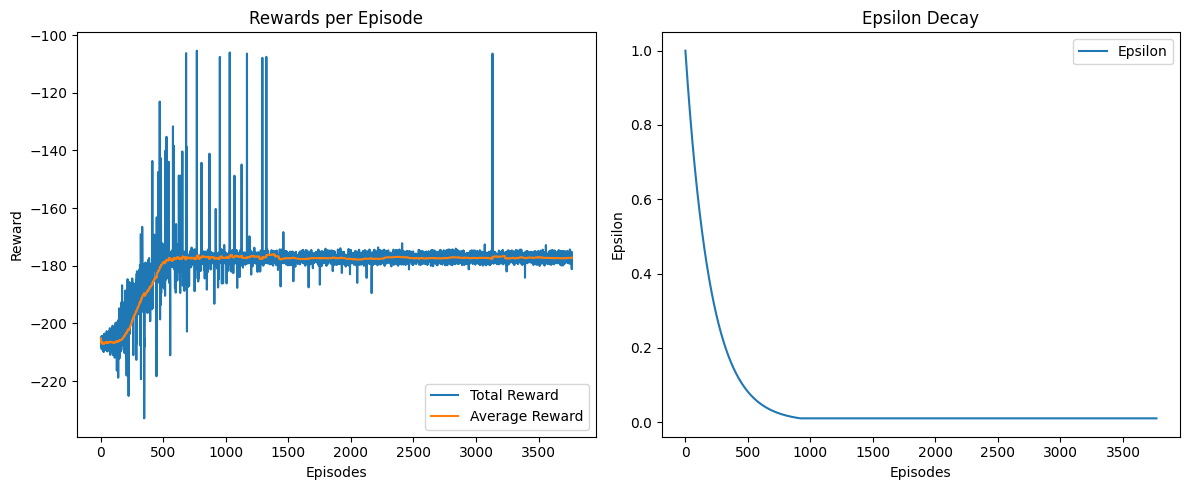

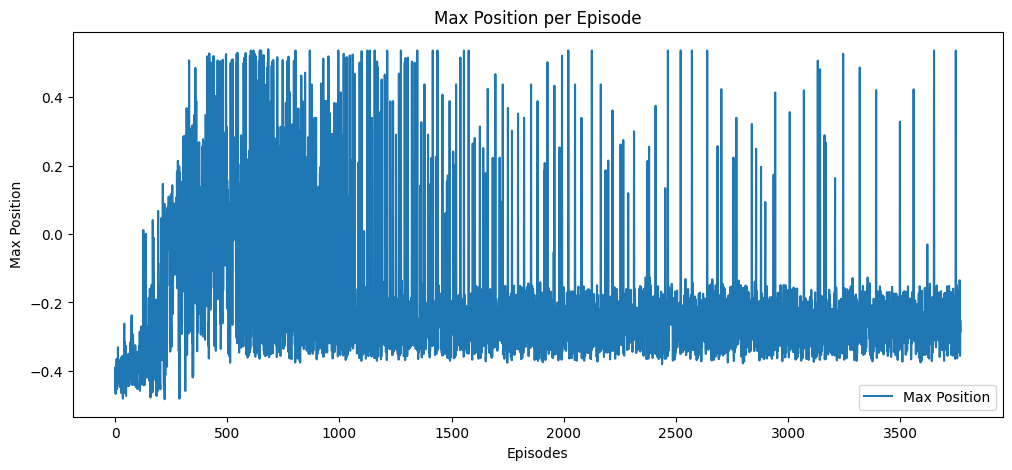

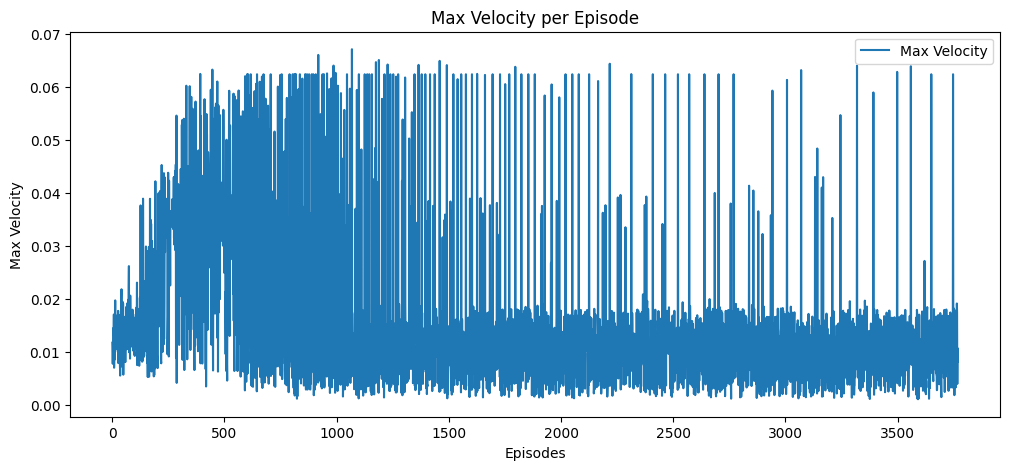

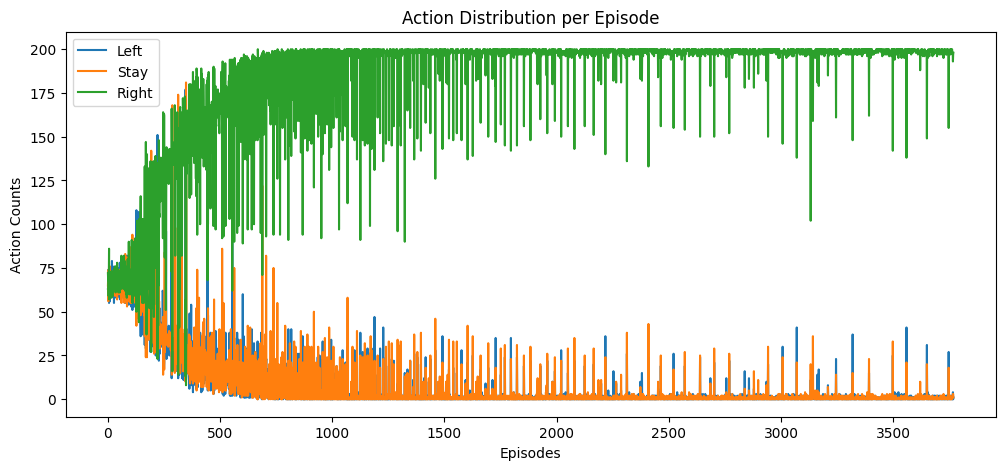

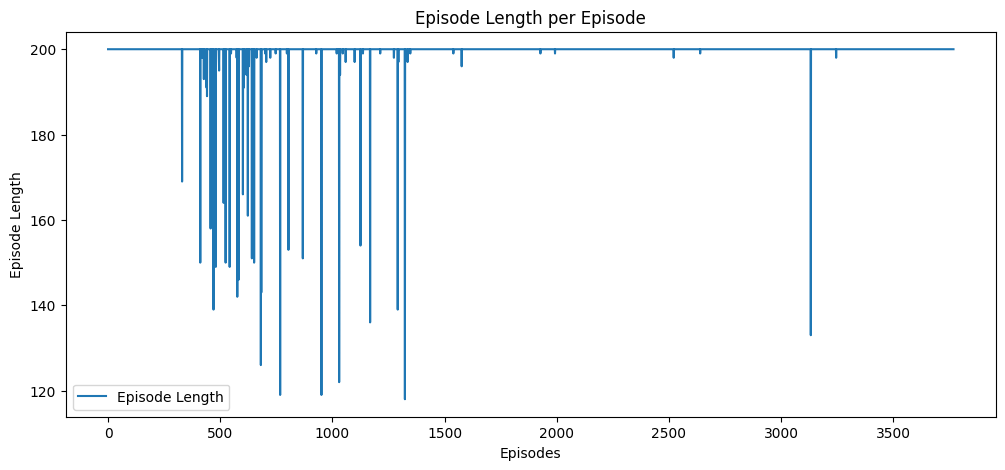

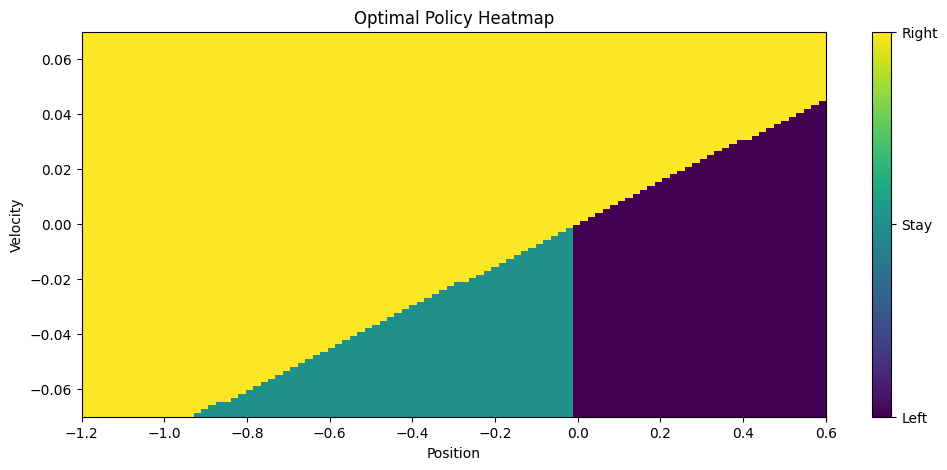

In [ ]:
# Funzione per creare e visualizzare la heatmap della policy ottimale
def plot_policy_heatmap(agent, position_range, velocity_range):
    positions = np.linspace(position_range[0], position_range[1], 100)
    velocities = np.linspace(velocity_range[0], velocity_range[1], 100)
    policy_grid = np.zeros((len(velocities), len(positions)))

    for i, velocity in enumerate(velocities):
        for j, position in enumerate(positions):
            state = np.array([position, velocity])
            action = agent.policy(state, epsilon=0.0)  # Policy deterministica
            policy_grid[i, j] = action

    plt.figure(figsize=(12, 5))
    plt.imshow(policy_grid, extent=[position_range[0], position_range[1], velocity_range[0], velocity_range[1]], aspect='auto', origin='lower', cmap='viridis')
    cbar = plt.colorbar(ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Left', 'Stay', 'Right'])
    plt.xlabel('Position')
    plt.ylabel('Velocity')
    plt.title('Optimal Policy Heatmap')
    plt.show()

# Plot delle ricompense e altre statistiche
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(rewards, label='Total Reward')
plt.plot(average_rewards, label='Average Reward')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.title('Rewards per Episode')
plt.legend()

# Grafico aggiuntivo per epsilon
plt.subplot(1, 2, 2)
epsilons = [max(0.01, 1.0 * (0.995 ** i)) for i in range(len(rewards))]
plt.plot(epsilons, label='Epsilon')
plt.xlabel('Episodes')
plt.ylabel('Epsilon')
plt.title('Epsilon Decay')
plt.legend()

plt.tight_layout()
plt.show()

# Plot della massima posizione raggiunta per episodio
plt.figure(figsize=(12, 5))
plt.plot(max_positions, label='Max Position')
plt.xlabel('Episodes')
plt.ylabel('Max Position')
plt.title('Max Position per Episode')
plt.legend()
plt.show()

# Plot della velocità massima raggiunta per episodio
plt.figure(figsize=(12, 5))
plt.plot(max_velocities, label='Max Velocity')
plt.xlabel('Episodes')
plt.ylabel('Max Velocity')
plt.title('Max Velocity per Episode')
plt.legend()
plt.show()

# Plot della distribuzione delle azioni
action_counts = np.array(action_counts)
actions = ['Left', 'Stay', 'Right']
plt.figure(figsize=(12, 5))
for i in range(len(actions)):
    plt.plot(action_counts[:, i], label=actions[i])
plt.xlabel('Episodes')
plt.ylabel('Action Counts')
plt.title('Action Distribution per Episode')
plt.legend()
plt.show()

# Plot della durata degli episodi
plt.figure(figsize=(12, 5))
plt.plot(episode_lengths, label='Episode Length')
plt.xlabel('Episodes')
plt.ylabel('Episode Length')
plt.title('Episode Length per Episode')
plt.legend()
plt.show()

# Plot della heatmap della policy ottimale
position_range = (-1.2, 0.6)
velocity_range = (-0.07, 0.07)
plot_policy_heatmap(agent, position_range, velocity_range)


# Visualizzazione dell'animazione migliore
In questa cella, mostriamo l'animazione del miglior episodio ottenuto durante l'addestramento.

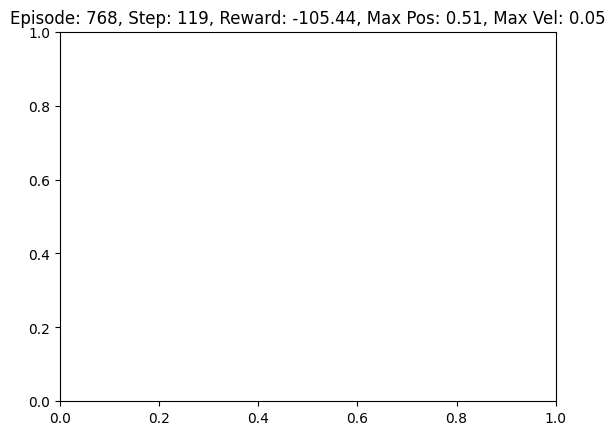

In [ ]:
# Salva i migliori pesi del modello
with open('linear_approx_best_weights.pkl', 'wb') as f:
    pickle.dump(best_weights, f)

# Visualizza l'animazione del miglior tentativo se disponibile
if best_frames:
    # Animazione del miglior tentativo
    anim_html = display_frames_as_gif(best_frames, info_text)
    display(anim_html)
else:
    print("Nessun miglior tentativo trovato.")
